In [1]:
import pandas as pd
from scipy.stats import pearsonr
from src import loader

MAGDIR = '/scratch/fl1092/MAG/2021-12-06/'
PROJDIR = '/scratch/fl1092/COIpaper/'

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib

cm = 1/2.54  # centimeters in inches
plt.rcParams.update({'font.size': 7})


matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['grid.linewidth'] = 0.5
matplotlib.rcParams['axes.linewidth'] = 0.5

plt.rcParams["pdf.use14corefonts"] = True
plt.rcParams["font.family"] = "sans-serif"

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)
    
pubColor = {
    'frontiers': '#e41a1c',
    'ieee': '#ff7f00',
    'mdpi': '#984ea3',
    'hindawi': '#4daf4a',
    'pnas': '#377eb8',
    'plos': '#ffff33'
}

delayColor = {
    False: '#1f78b4',
    True: '#ff7f00'
}

# Load data

In [3]:
%%time
papAuSeq = pd.read_csv(MAGDIR+"mag/PaperAuthorAffiliations.txt", sep="\t",
                      names = ['PaperId', 'AuthorId', 'AffiliationId', 'AuthorSequenceNumber', 
                               'OriginalAuthor', 'OriginalAffiliation'],
                      usecols = ['PaperId', 'AuthorId', 'AuthorSequenceNumber'], 
                    dtype = {'PaperId':int, 'AuthorId':int, 'AuthorSequenceNumber':int}, memory_map=True)

authorCount = pd.read_csv(MAGDIR + 'derived/PaperAuthorCount.csv', sep='\t')

CPU times: user 7min 49s, sys: 1min 1s, total: 8min 51s
Wall time: 9min 18s


In [4]:
sameAff = pd.read_csv(PROJDIR + 'EditorAuthorSameAff.csv')

coipapers = pd.read_csv(PROJDIR + 'COI48MonthPapers.csv',sep='\t')
coi24papers = pd.read_csv(PROJDIR + 'COI24MonthPapers.csv',sep='\t')
coi36papers = pd.read_csv(PROJDIR + 'COI36MonthPapers.csv',sep='\t')
coi60papers = pd.read_csv(PROJDIR + 'COI60MonthPapers.csv',sep='\t')

In [5]:
pastCollaboration = pd.read_csv('/scratch/fl1092/followup-editors/collab/PastCollaboration.csv')
authorsCollaborated = pd.read_csv('/scratch/fl1092/COIpaper/NoAuthorsCollab.csv',sep='\t')
minPastAuthorCount = pd.read_csv('/scratch/fl1092/COIpaper/MinPastAuthorCount.csv',sep='\t')

In [6]:
papEditor = loader.loadPaperEditor()
assert(papEditor.shape[0] == papEditor[['PaperId','EditorId']].drop_duplicates().shape[0])
assert(papEditor.shape[0] == papEditor.PaperId.nunique())

info = loader.loadPaperInfo()
info = info[info.PaperId.isin(papEditor.PaperId)]

recvDate, acptDate = loader.loadPaperRecvAcptTime()

In [7]:
def generatePlot(info, attribute, coi):
    
    return (
        info

        .merge(attribute, on='PaperId')
        .merge(coi.assign(COI=True), on='PaperId', how='left')
        .fillna({'COI':False})
    )

def overallCOIRate(collab, aff):
    
    overall = (
        pd.merge(
            collab.rename(columns={'COI':'CollabCOI'}),
            aff.rename(columns={'COI':'AffCOI'}),
            on=['PaperId','Journal','Publisher'])
        .assign(COI = lambda df: df.apply(lambda row: row['AffCOI'] or row['CollabCOI'], axis=1))
    )
    
    return overall

In [8]:
collabPlot = generatePlot(info, info[['PaperId']], coipapers)
affPlot = generatePlot(info, info[['PaperId']], sameAff[['PaperId']].drop_duplicates())
overallPlot = overallCOIRate(collabPlot, affPlot)

In [9]:
collabPlot.drop(['PaperId'],axis=1).to_csv('./data/PapersCollab.csv')
affPlot.drop(['PaperId'],axis=1).to_csv('./data/PapersAff.csv')
overallPlot.drop(['PaperId'],axis=1).to_csv('./data/PapersOverall.csv')

# Process attributes
## Process editor attributes

In [10]:
%%time
rank = (
    pd.read_csv('./data/shanghai_ranking.csv',sep=',',
                usecols=['AffID','rank'], dtype={'AffID':int,'rank':str})
    .rename(columns={'AffID':'AffiliationId'})
)
rank = rank.assign(rank=rank['rank'].apply(lambda x: x.split('-')[0]))
rank = rank.assign(rank=rank['rank'].astype(int))
rank = rank.rename(columns={'rank':'Rank'})

auAffYear = pd.read_csv(MAGDIR+'derived/AuthorAffiliationYear.csv',sep='\t')

CPU times: user 22.4 s, sys: 3.19 s, total: 25.6 s
Wall time: 25.8 s


In [11]:
%%time
def binRank(x):
    if x<= 10: return 0
    if x<= 20: return 1
    if x<= 50: return 2
    if x<= 100: return 3
    if x<= 200: return 4
    if x<= 500: return 5
    if x<= 1000: return 6
    if x> 1000: return 7

papEditorRank = (
    papEditor.merge(recvDate, on='PaperId')
    
    .merge(auAffYear.rename(columns={'AuthorId':'EditorId'}), on=['EditorId','Year'])
    .merge(rank, on='AffiliationId', how='left')
    .fillna({'Rank':1001})
    
    .groupby(['PaperId','EditorId']).Rank.min().reset_index()
    .assign(RankBin = lambda df: df.Rank.apply(binRank))
    
    [['PaperId','RankBin']]
)

CPU times: user 49.9 s, sys: 6.56 s, total: 56.5 s
Wall time: 57.4 s


In [12]:
%%time
fieldname = (
    pd.read_csv(MAGDIR + "advanced/FieldsOfStudy.txt", sep="\t", 
                names = ["FieldOfStudyId", "Rank", "NormalizedName", "DisplayName", 
                         "MainType","Level","PaperCount","PaperFamilyCount", "CitationCount","CreatedDate"],
                usecols=['FieldOfStudyId', 'DisplayName']
               )
    .rename(columns={'FieldOfStudyId':'Field', 'DisplayName':'FieldName'})
    .dropna()
)

paperField = (
    pd.read_csv('/scratch/fl1092/followup-editors/PaperField.csv',
                sep='\t', dtype={'PaperId':int}, usecols=['PaperId','Field'])
    .merge(fieldname, on='Field')
    .drop('Field', axis=1)
)

CPU times: user 1.66 s, sys: 137 ms, total: 1.8 s
Wall time: 1.92 s


## Process author position on focal paper and on previous collaboration

In [13]:
%%time
auSeqSubset = papAuSeq[
    (papAuSeq.PaperId.isin(pastCollaboration.ColabPaperId)) | 
    (papAuSeq.PaperId.isin(pastCollaboration.PaperId)) |
    (papAuSeq.PaperId.isin(sameAff.PaperId))
]

lastAuthorPos = auSeqSubset.groupby('PaperId').AuthorSequenceNumber.max().reset_index()

auSeqSubset = (
    auSeqSubset.merge(lastAuthorPos.assign(Last=True), on=['PaperId','AuthorSequenceNumber'], how='left')
    .fillna({'Last': False})
    
    .assign(First=lambda df: df.AuthorSequenceNumber == 1)
    .assign(FirstorLast = lambda df: df.apply(lambda row: row.Last or row.First, axis=1))
    .assign(Middle=lambda df: df.apply(lambda row: row.Last!=True and row.First!=True, axis=1))
    
    .drop_duplicates()
)

assert(((auSeqSubset.FirstorLast.apply(lambda x: int(x)) + auSeqSubset.Middle.apply(lambda x: int(x))) == 1).all())

CPU times: user 1min 17s, sys: 2.84 s, total: 1min 20s
Wall time: 1min 55s


In [14]:
%%time
pastCollabAttr = (
    pastCollaboration.query('MonthGap <= 48')
    .merge(auSeqSubset, on=['PaperId','AuthorId'], how='left')
)

sameAffAttr = sameAff.merge(auSeqSubset, on=['PaperId','AuthorId'], how='left')

CPU times: user 936 ms, sys: 6.8 ms, total: 943 ms
Wall time: 1.89 s


# Distribution
## Plot publisher

In [15]:
def annotateBar(ax, toPlot, x, y):
    gap = 0.001
    
    for ind, row in toPlot.iterrows():
        ax.text(y=ind, x=row[y] - gap, s=str(round(-row[y]*100, 1))+'%', ha='right', va='center')

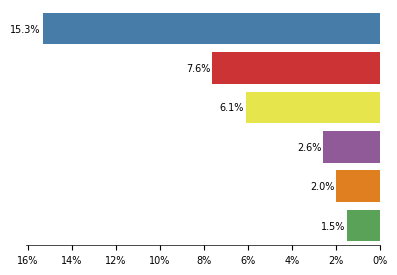

In [16]:
publisherPlot = (
    overallPlot.groupby('Publisher').COI.mean().reset_index()
    .sort_values(by='COI',ascending=False)
    .reset_index(drop=True)
    .assign(COI=lambda df: df.COI.apply(lambda x: -x))
)

ax = plt.gca()

set_size(9*cm, 6*cm, ax)

sns.barplot(data=publisherPlot, y='Publisher', x='COI', linewidth=0.5, ax=ax, palette=pubColor, orient='h')
annotateBar(ax, publisherPlot, x='Publisher', y='COI')

ax.set_ylabel('') # Fraction of COI papers
ax.set_xlabel('')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.tick_params(axis='y',length=0)

ax.set_xticks([-x/100 for x in range(0, 17, 2)])
ax.set_xticklabels([f'{x}%' for x in range(0, 17, 2)])

ax.set_yticks([])

plt.savefig('./figures/Publisher_collab&aff.pdf', bbox_inches = 'tight', pad_inches = 0)

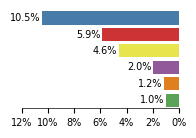

In [17]:
publisherPlot = (
    collabPlot.groupby('Publisher').COI.mean().reset_index()
    .sort_values(by='COI',ascending=False)
    .reset_index(drop=True)
    .assign(COI=lambda df: df.COI.apply(lambda x: -x))
)

ax = plt.gca()

set_size(4*cm, 2.5*cm, ax)

sns.barplot(data=publisherPlot, y='Publisher', x='COI', linewidth=0.5, ax=ax, palette=pubColor, orient='h')
annotateBar(ax, publisherPlot, x='Publisher', y='COI')

ax.set_ylabel('') # Fraction of COI papers
ax.set_xlabel('')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.tick_params(axis='y',length=0)

ax.set_xticks([-x/100 for x in range(0, 13, 2)])
ax.set_xticklabels([f'{x}%' for x in range(0, 13, 2)])

ax.set_yticks([])

plt.savefig('./figures/Publisher_collab.pdf', bbox_inches = 'tight', pad_inches = 0)

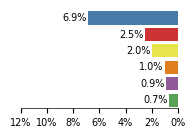

In [18]:
publisherPlot = (
    affPlot.groupby('Publisher').COI.mean().reset_index()
    .sort_values(by='COI',ascending=False)
    .reset_index(drop=True)
    .assign(COI=lambda df: df.COI.apply(lambda x: -x))
)

ax = plt.gca()

set_size(4*cm, 2.5*cm, ax)

sns.barplot(data=publisherPlot, y='Publisher', x='COI', linewidth=0.5, ax=ax, palette=pubColor, orient='h')
annotateBar(ax, publisherPlot, x='Publisher', y='COI')

ax.set_ylabel('') # Fraction of COI papers
ax.set_xlabel('')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.tick_params(axis='y',length=0)

ax.set_xticks([-x/100 for x in range(0, 13, 2)])
ax.set_xticklabels([f'{x}%' for x in range(0, 13, 2)])

ax.set_yticks([])

plt.savefig('./figures/Publisher_aff.pdf', bbox_inches = 'tight', pad_inches = 0)

## Special issues

In [19]:
specialIssue = pd.read_csv('/scratch/fl1092/COIpaper/special_issue/SpecialIssuePapers.csv',usecols=['PaperId'])

In [20]:
normalPaper = (
    info[info.Publisher.isin(['frontiers','mdpi','hindawi'])]
    
    .merge(specialIssue.assign(SI=1), on='PaperId', how='left')
    .fillna({'SI': 0})
    .query('SI == 0')
    
    [['PaperId']]
)

In [21]:
specialAff = generatePlot(info, specialIssue, sameAff[['PaperId']].drop_duplicates())
normalAff = generatePlot(info, normalPaper, sameAff[['PaperId']].drop_duplicates())

specialCollab = generatePlot(info, specialIssue, coipapers)
normalCollab = generatePlot(info, normalPaper, coipapers)

specialOverall = overallCOIRate(specialCollab, specialAff)
normalOverall = overallCOIRate(normalCollab, normalAff)

In [22]:
def formatPercentage(df):
    
    return (
        df.groupby('Publisher').COI.mean().reset_index()
        
        .sort_values(by='Publisher')
        .reset_index(drop=True)
    
        .assign(COI=lambda df: df.COI.apply(lambda x: f'{round(x*100, 2)}%'))
    )

In [23]:
(
    formatPercentage(normalAff)
    .merge(formatPercentage(specialAff), on='Publisher')
    
    .merge(formatPercentage(normalCollab), on='Publisher')
    .merge(formatPercentage(specialCollab), on='Publisher')
    
    .merge(formatPercentage(normalOverall), on='Publisher')
    .merge(formatPercentage(specialOverall), on='Publisher')
)

/state/partition1/job-45262340/ipykernel_3875762/1636320696.py:2: FutureWarning: Passing 'suffixes' which cause duplicate columns {'COI_x'} in the result is deprecated and will raise a MergeError in a future version.
  formatPercentage(normalAff)
/state/partition1/job-45262340/ipykernel_3875762/1636320696.py:2: FutureWarning: Passing 'suffixes' which cause duplicate columns {'COI_x'} in the result is deprecated and will raise a MergeError in a future version.
  formatPercentage(normalAff)


,Publisher,COI_x,COI_y,COI_x,COI_y,COI_x,COI_y
0,frontiers,1.42%,3.29%,3.22%,7.77%,4.35%,9.95%
1,hindawi,0.45%,3.26%,0.65%,4.69%,1.0%,6.68%
2,mdpi,0.73%,0.99%,1.54%,2.13%,2.01%,2.77%


## Plot journals

In [24]:
journalPlot = (
    overallPlot.groupby(['Journal','Publisher']).COI.mean().reset_index()
    .merge(
        info.groupby(['Journal','Publisher']).PaperId.nunique()
        .reset_index().rename(columns={'PaperId':'Count'}), on=['Journal','Publisher'])
    .query('Count >= 100')
    .drop('Count',axis=1)
    .sort_values(by='COI',ascending=False)
    .reset_index(drop=True)
)

In [25]:
journalPlot.to_csv('./data/JournalPercentage.csv',index=False)

In [26]:
journalPlot.head(20)

,Journal,Publisher,COI
0,PLoS_Med,plos,0.242802
1,Front_Pediatr,frontiers,0.158801
2,PNAS,pnas,0.153247
3,jof,mdpi,0.148936
4,PLoS_Negl_Trop_Dis,plos,0.148285
5,Front_Neuroinform,frontiers,0.140515
6,toxins,mdpi,0.119850
7,Front_Neurol,frontiers,0.115182
8,Front_Integr_Neurosci,frontiers,0.112457
9,Front_Cardiovasc_Med,frontiers,0.111693


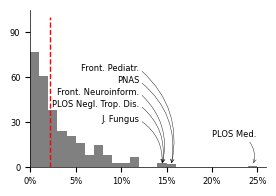

In [27]:
ax = plt.gca()

set_size(6*cm, 4*cm, ax)

binSize=10
bins=[x/1000 for x in range(0, 250+binSize, binSize)]

ax.hist(journalPlot.COI, bins=bins, color='grey')
ax.set_xticks(bins[::5])
ax.set_xticklabels([str(int(x*100))+'%' for x in bins[::5]], fontsize=6)
ax.set_xlim(0, 0.26)

ax.set_yticks([0, 30, 60, 90])
ax.set_yticklabels([0, 30, 60, 90], fontsize=6)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.plot([journalPlot.COI.describe()['50%'], journalPlot.COI.describe()['50%']],
        [0, 100], color='red', ls='--', lw=1) # plot median


ax.annotate(
    'PLOS Med.', xy=(0.245, 1), xycoords='data',fontsize=6, xytext=(0.20, 20), textcoords='data',
    horizontalalignment='left',
    arrowprops=dict(arrowstyle="->",linewidth=0.3,shrinkA=0,relpos=(0.8,0),connectionstyle="arc3,rad=-0.3")
)

ax.annotate(
    'J. Fungus', xy=(0.145, 1), xycoords='data',fontsize=6, xytext=(0.12, 30), textcoords='data',
    horizontalalignment='right',
    arrowprops=dict(arrowstyle="->",linewidth=0.3,shrinkA=0,relpos=(1,0.5),connectionstyle="arc3,rad=-0.3")
)

ax.annotate(
    'PLOS Negl. Trop. Dis.', xy=(0.145, 1), xycoords='data',fontsize=6, xytext=(0.12, 40), textcoords='data',
    horizontalalignment='right',
    arrowprops=dict(arrowstyle="->",linewidth=0.3,shrinkA=0,relpos=(1,0.5),connectionstyle="arc3,rad=-0.3")
)

ax.annotate(
    'Front. Neuroinform.', xy=(0.145, 1), xycoords='data',fontsize=6, xytext=(0.12, 48), textcoords='data',
    horizontalalignment='right',
    arrowprops=dict(arrowstyle="->",linewidth=0.3,shrinkA=0,relpos=(1,0.5),connectionstyle="arc3,rad=-0.3")
)

ax.annotate(
    'Front. Pediatr.', xy=(0.155, 1), xycoords='data',fontsize=6, xytext=(0.12, 64), textcoords='data',
    horizontalalignment='right',
    arrowprops=dict(arrowstyle="->",linewidth=0.3,shrinkA=0,relpos=(1,0.5),connectionstyle="arc3,rad=-0.3")
)

ax.annotate(
    'PNAS', xy=(0.155, 1), xycoords='data',fontsize=6, xytext=(0.12, 56), textcoords='data',
    horizontalalignment='right',
    arrowprops=dict(arrowstyle="->",linewidth=0.3,shrinkA=0,relpos=(1,0.5),connectionstyle="arc3,rad=-0.3")
)

plt.savefig('./figures/Journals_collab&aff.pdf', bbox_inches = 'tight', pad_inches = 0)

# Break down of percentage by discipline and rank

In [28]:
import numpy as np
import scipy
from tqdm.notebook import tqdm

def getCI(data, confidence=0.95):
    
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    
    return m, h

def calcPercent(collab, aff, attrDf, col):
    
    collabPlot = generatePlot(info, info[['PaperId']], collab)
    affPlot = generatePlot(info, info[['PaperId']], aff)
    
    overallPlot = (
        overallCOIRate(collabPlot, affPlot)
        .merge(attrDf, on='PaperId')
        .groupby(col).agg({'COI': getCI}).reset_index()
    )
    
    return overallPlot

def plotCI(df, x, col='COI', x_col='', width=6, ax=None, lo=0, hi=0.14, left=-0.5, right=1.5):
    
    if ax is None: ax = plt.gca()
    
    color = '#e41a1c'
        
    means = df[col].apply(lambda x: x[0])
    errs = df[col].apply(lambda x: x[1])
    
    errs = df[col].apply(lambda x: x[1])
    
    plotline, caplines, barlinecols = ax.errorbar(
        x=x, y=means, yerr=errs, fmt = ' ', marker='_', ms=width+1, ecolor=(0, 0, 0, 0.2),
        elinewidth=width, capsize=0, color=color
    )

    plt.setp(barlinecols[0], capstyle="round", color=color, alpha=0.2)
    
    ax.set_xlim(left, right)
    ax.set_ylim(lo, hi)

    ax.set_xticks(x)
    ax.set_xticklabels(df[x_col], rotation=90)


    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlabel('')
    ax.set_ylabel('')

## By rank

In [29]:
rankPlot = (
    calcPercent(coipapers, sameAff[['PaperId']].drop_duplicates(), papEditorRank, 'RankBin')
    .merge(pd.DataFrame([
        {'RankBin': 0, 'RankRange': '1-10'},
        {'RankBin': 1, 'RankRange': '11-20'},
        {'RankBin': 2, 'RankRange': '21-50'},
        {'RankBin': 3, 'RankRange': '51-100'},
        {'RankBin': 4, 'RankRange': '101-200'},
        {'RankBin': 5, 'RankRange': '201-500'},
        {'RankBin': 6, 'RankRange': '501-1000'},
        {'RankBin': 7, 'RankRange': '1000+'},
    ]), on='RankBin', how='left')
)

In [30]:
rankPlot

,RankBin,COI,RankRange
0,0,"(0.1186830854678993, 0.0038319700432451927)",1-10
1,1,"(0.09764911598989703, 0.003626909772874812)",11-20
2,2,"(0.0738280176827593, 0.002561423889790429)",21-50
3,3,"(0.06690639225737348, 0.002141818255538484)",51-100
4,4,"(0.059431596158909195, 0.001725015286428984)",101-200
5,5,"(0.045846031535709555, 0.0012183777322716204)",201-500
6,6,"(0.03506327795427321, 0.0013008928225235654)",501-1000
7,7,"(0.04641001166613639, 0.001342795358178044)",1000+


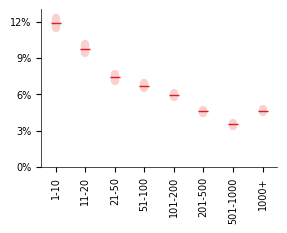

In [31]:
ax = plt.gca()
set_size(6*cm, 4*cm, ax)

plotCI(
    rankPlot.sort_values(by='RankBin',ascending=True), rankPlot.index, col='COI', ax=ax, x_col='RankRange',
    lo=0, hi=0.13, left=-0.5, right=7.5
)

ax.set_yticks([0, 0.03, 0.06, 0.09, 0.12])
ax.set_yticklabels(['0%', '3%', '6%', '9%', '12%'])

plt.savefig('./figures/Overall_rank.pdf', bbox_inches = 'tight', pad_inches = 0)

## By discipline

In [32]:
fieldPlot = (
    calcPercent(coipapers, sameAff[['PaperId']].drop_duplicates(), paperField, 'FieldName')
    .assign(
        FieldNameAbbr = lambda df: df.FieldName.apply(
            lambda x: x.replace('science','sci.').replace('Environmental','Environ.')
        )
    )
)

In [33]:
fieldPlot

,FieldName,COI,FieldNameAbbr
0,Art,"(0.05504896994258696, 0.008219759418662901)",Art
1,Biology,"(0.06548541252973138, 0.0008560635367494478)",Biology
2,Business,"(0.027642028100183264, 0.003971963589859216)",Business
3,Chemistry,"(0.06478366912878131, 0.001159819835525343)",Chemistry
4,Computer science,"(0.034466679619195646, 0.0015760456604785023)",Computer sci.
5,Economics,"(0.03577573420350044, 0.0028042136053819796)",Economics
6,Engineering,"(0.02806461287972921, 0.0014983252909113265)",Engineering
7,Environmental science,"(0.04648029639609296, 0.00757691761761861)",Environ. sci.
8,Geography,"(0.04850319542549613, 0.0034538577834205123)",Geography
9,Geology,"(0.058183978100304734, 0.002331702438871233)",Geology


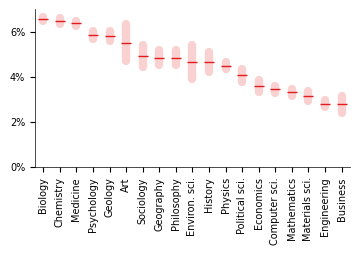

In [34]:
ax = plt.gca()
set_size(8*cm, 4*cm, ax)

plotCI(
    fieldPlot.sort_values(by='COI',ascending=False), fieldPlot.index, col='COI', ax=ax, x_col='FieldNameAbbr',
    lo=0, hi=0.07, left=-0.5, right=18.5
)

ax.set_yticks([0, 0.02, 0.04, 0.06])
ax.set_yticklabels(['0%', '2%', '4%', '6%'])

plt.savefig('./figures/Overall_discipline.pdf', bbox_inches = 'tight', pad_inches = 0)

# Breakdown by other attributes

In [35]:
def collabTimesBin(x):
    
    if x <=5: return x
    else: return 6

collabTimes = (
    pastCollaboration.query('MonthGap <= 48')
    
    .groupby(['PaperId']).ColabPaperId.nunique().reset_index()
    .rename(columns={'ColabPaperId':'CollabTimes'})
    
    .assign(CollabTimesBin=lambda df: df.CollabTimes.apply(collabTimesBin))
    
    .CollabTimesBin.value_counts(normalize=True).reset_index()
    .rename(columns={'index': 'CollabTimesBin', 'CollabTimesBin': 'Percentage'})
)

In [36]:
collabTimes

,CollabTimesBin,Percentage
0,1,0.477329
1,2,0.193705
2,6,0.134270
3,3,0.099869
4,4,0.056689
5,5,0.038138


In [37]:
# time since the most recent collaboration
def gapBin(x):
    if x <= 12: return 1
    elif x<= 24: return 2
    elif x<= 36: return 3
    elif x<= 48: return 4


collabMinGap = (
    pastCollaboration.query('MonthGap <= 48')
    
    .groupby(['PaperId']).MonthGap.min().reset_index()
    
    .assign(MonthGapBin = lambda df: df.MonthGap.apply(gapBin))
    .MonthGapBin.value_counts(normalize=True).reset_index()
    
    .rename(columns={'index': 'MonthGapBin', 'MonthGapBin':'Percentage'})
)

In [38]:
collabMinGap

,MonthGapBin,Percentage
0,1,0.472016
1,2,0.227295
2,3,0.168040
3,4,0.132649


In [39]:
def teamSizeBin(x):
    if x==2: return 2
    elif x<= 5: return 3
    elif x<= 10: return 4
    elif x<= 20: return 5
    elif x<= 50: return 6
    else: return 7

collabMinTeamSize = (
    pastCollaboration.query('MonthGap <= 48')
    
    .groupby(['PaperId']).ColabAuthorCount.min().reset_index()
    .rename(columns={'ColabAuthorCount':'TeamSize'})
    
    .assign(TeamSizeBin = lambda df: df.TeamSize.apply(teamSizeBin))
    
    .TeamSizeBin.value_counts(normalize=True)
    .reset_index()
    
    .rename(columns={'index':'TeamSizeBin', 'TeamSizeBin':'Percentage'})
)

In [40]:
collabMinTeamSize

,TeamSizeBin,Percentage
0,4,0.294205
1,3,0.279436
2,5,0.184024
3,6,0.096267
4,7,0.084380
5,2,0.061687


In [41]:
total = (
    pd.concat([
        pastCollaboration.query('MonthGap <= 48'), sameAff], ignore_index=True, sort=False
    )
    [['PaperId']].drop_duplicates()
)

first = (
    pd.concat([
        pastCollabAttr.query('First == True'),
        sameAffAttr.query('First == True')], ignore_index=True, sort=False)
    
    [['PaperId']].drop_duplicates()
)

last = (
    pd.concat([
        pastCollabAttr.query('Last == True'),
        sameAffAttr.query('First == True')], ignore_index=True, sort=False)
    
    [['PaperId']].drop_duplicates()
)

firstOrLast = (
    pd.concat([
        pastCollabAttr.query('Middle == False'),
        sameAffAttr.query('Middle == False')], ignore_index=True, sort=False)
    
    [['PaperId']].drop_duplicates()
)

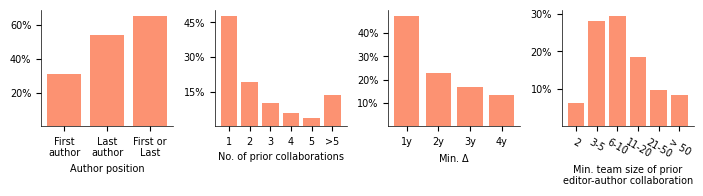

In [42]:
plt.figure(figsize=(17.9*cm, 5*cm))

axes = [plt.subplot(1, 4, x) for x in range(1, 5)]

axes[0].bar([0, 1, 2], [first.shape[0]/total.shape[0],
                        last.shape[0]/total.shape[0],
                        firstOrLast.shape[0]/total.shape[0]], color='#fc9272')
axes[0].set_xticks([0, 1, 2])
axes[0].set_xticklabels(['First\nauthor', 'Last\nauthor', 'First or\nLast'])
axes[0].set_xlabel('Author position')
axes[0].set_yticks([0.2, 0.4, 0.6])
axes[0].set_yticklabels(['20%', '40%', '60%'])


axes[1].bar(collabTimes.CollabTimesBin, collabTimes.Percentage, color='#fc9272')
axes[1].set_xticks([1, 2, 3, 4, 5, 6])
axes[1].set_xticklabels(['1', '2', '3', '4', '5', '>5'])
axes[1].set_xlabel('No. of prior collaborations')
axes[1].set_yticks([0.15, 0.3, 0.45])
axes[1].set_yticklabels(['15%', '30%', '45%'])


axes[2].bar(collabMinGap.MonthGapBin, collabMinGap.Percentage, color='#fc9272')
axes[2].set_xticks([1, 2, 3, 4])
axes[2].set_xticklabels(['1y', '2y', '3y', '4y'])
axes[2].set_xlabel('Min. $\Delta$')
axes[2].set_yticks([0.1, 0.2, 0.3, 0.4])
axes[2].set_yticklabels(['10%', '20%', '30%', '40%'])


axes[3].bar(collabMinTeamSize.TeamSizeBin, collabMinTeamSize.Percentage, color='#fc9272')
axes[3].set_xticks([2, 3, 4, 5, 6, 7])
axes[3].set_xticklabels([2, '3-5', '6-10', '11-20', '21-50', '> 50'])
axes[3].tick_params(axis='x', rotation=-30)
axes[3].set_xlabel('Min. team size of prior\neditor-author collaboration')
axes[3].set_yticks([0.1, 0.2, 0.3])
axes[3].set_yticklabels(['10%', '20%', '30%'])


for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


plt.tight_layout()
plt.savefig('./figures/Breakdown_percentage.pdf', bbox_inches = 'tight', pad_inches = 0)

# Relative acceptance delay (RAD)

In [43]:
def plotDelayDist(ax, delayPlot):

    g = sns.histplot(
        delayPlot, x="RelativeDelay", hue="COI", ax=ax, palette=delayColor,
        stat="probability", common_norm=False, kde=True, bins=500, linewidth=0
    )
    g.legend_.remove()

    ax.set_xlim(-165, 165)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_yticks([x/10000 for x in range(0, 201, 50)])
    ax.set_yticklabels([f'{x/100}%' for x in range(0, 201, 50)])

    ax.set_xticks([x for x in range(-150, 151, 75)])
    ax.set_xticklabels([str(x) for x in range(-150, 151, 75)])

def plotBox(ax, delayPlot):
    
    ax.boxplot(
        delayPlot.query('COI==True').RelativeDelay,
        patch_artist=True,positions=[1],
        vert=False,showfliers=False,widths=0.6,
        boxprops=dict(facecolor=hexToDecimal(delayColor[True], 0.5)),
        medianprops=dict(color='black'),
    )
    
    ax.boxplot(
        delayPlot.query('COI==False').RelativeDelay,
        patch_artist=True,positions=[2],
        vert=False,showfliers=False,widths=0.6,
        boxprops=dict(facecolor=hexToDecimal(delayColor[False], 0.5)),
        medianprops=dict(color='black'),
    )
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    
    ax.set_xlim(-165, 165)

def hexToDecimal(h, alpha=1):
    h = h.strip('#')
    return tuple(int(h[i:i+2], 16)/255 if i<6 else alpha for i in (0, 2, 4, 6))

In [44]:
%%time
paperDelay = (
    loader.loadPaperDelay(percentage=True)
    .drop(['Journal','Publisher'], axis=1)
    .assign(RelativeDelay = lambda df: df.AcptDelay - df.JAvg)
)

delayPlot = generatePlot(info, paperDelay, coipapers)

CPU times: user 5.92 s, sys: 266 ms, total: 6.19 s
Wall time: 12.6 s


In [45]:
delayPlot.drop(['PaperId','Year','AcptDelay','JAvg'],axis=1).to_csv('./data/RelativeAcceptanceDelay.csv')

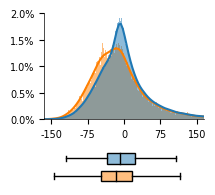

In [46]:
plt.rcParams.update({'font.size': 7})

f, (adist, abox) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [6, 2]})

f.set_size_inches(5.5*cm, 5*cm)

plotDelayDist(adist, delayPlot=delayPlot)
plotBox(abox, delayPlot=delayPlot)

plt.tight_layout()

plt.savefig('./figures/Delay_hist.pdf', bbox_inches = 'tight', pad_inches = 0)

## RAD breakdown by teamsize of recent collaboration

In [47]:
def binPercentCollab(x):
    
    if x <= 0.1:
        return 0
    elif x <= 0.2:
        return 1
    elif x <= 0.3:
        return 2
    elif x <= 0.5:
        return 3
    else:
        return 4
    
def binPastAuthorCount(x):
    
    if x<=3:
        return 4
    elif x<=10:
        return 3
    elif x<=20:
        return 2
    elif x<=50:
        return 1
    else:
        return 0

In [48]:
%%time
COIDelayPlot = (
    delayPlot.query('COI == True')
    .merge(
        authorCount[authorCount.PaperId.isin(delayPlot.query('COI == True').PaperId)]
        .rename(columns={'AuthorCount':'TotalNumberOfAuthors'}), on='PaperId'
    )
    
    .merge(authorsCollaborated, on='PaperId')
    .merge(minPastAuthorCount, on='PaperId')
    
    .assign(PercentCollabAuthor = lambda df: df.NoCollabAuthor / df.TotalNumberOfAuthors)
    .assign(BinPercent = lambda df: df.PercentCollabAuthor.apply(binPercentCollab))
    .assign(PastAuthorBin = lambda df: df.MinPastAuthorCount.apply(binPastAuthorCount))
    
)
print(COIDelayPlot.shape)

(21760, 14)
CPU times: user 4.84 s, sys: 611 ms, total: 5.45 s
Wall time: 11 s


In [49]:
(
    COIDelayPlot
    .drop(['PaperId','Year','AcptDelay','JAvg','TotalNumberOfAuthors','NoCollabAuthor','MinPastAuthorCount'],axis=1)
    .to_csv('./data/RAD_correlation.csv')
)

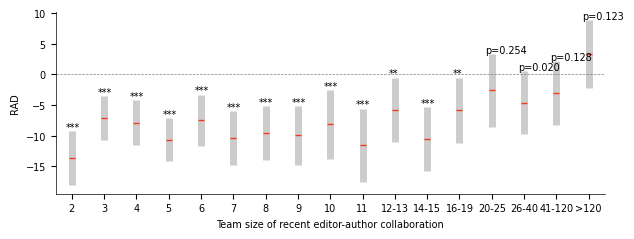

In [50]:
from scipy.stats import ttest_1samp
import numpy as np
import scipy.stats

def mean_confidence_interval(data, confidence=0.99):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

# smallest bins with integer ranges that contains at least 5% of data

plt.figure(figsize=(18*cm, 6*cm))

bins = [0,2,3,4,5,6,7,8,9,10,11,13,15,19,25,40,120,5363]

ax = plt.gca()

for ind in range(1, len(bins)):
    lo = bins[ind-1]
    hi = bins[ind]
    
    subDf = COIDelayPlot.query('MinPastAuthorCount <= @hi & MinPastAuthorCount > @lo')
    vals = subDf.RelativeDelay.values
    
    y, errs = mean_confidence_interval(vals)
    
    ttest = ttest_1samp(vals, 0)
    
    plotline, caplines, barlinecols = ax.errorbar(
        x=ind, y=y, yerr=errs, fmt = ' ', marker='_', ms=5, ecolor=(0, 0, 0, 0.2),
        elinewidth=5, capsize=0, color='#f03b20'
    )
    
    p = ttest.pvalue
    pvaltext = 'p={:.3f}'.format(p) if p >= 0.01 else '***' if p < 0.001 else '**'
    plt.text(ind-0.2, y + errs + 0.2, pvaltext)
    
ax.set_xticks([ind for ind in range(1, len(bins))])
ax.set_xticklabels(['2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
                    '12-13', '14-15', '16-19', '20-25', '26-40', '41-120', '>120'])
    
ax.plot([0.5, 17.5],[0,0], lw=0.5, color='grey', ls='--')
ax.set_xlim(0.5, 17.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Team size of recent editor-author collaboration')
ax.set_ylabel('RAD')

plt.savefig('./figures/RAD_teamsize_20bins.pdf',bbox_inches = 'tight', pad_inches = 0)

## RAD break down by other attributes

In [51]:
def binPercentCollab(x):
    
    if x <= 0.1:
        return 0
    elif x <= 0.2:
        return 1
    elif x <= 0.3:
        return 2
    elif x <= 0.5:
        return 3
    else:
        return 4

In [52]:
def plotPvalue(ax, x, height, pVal, gap, vlength, lw=0.2, c='black', direction=1):
    # x: [x0, x1]
    # y: [y0, y1]
    
    yPos = height + (gap + vlength) * direction
    ax.hlines(yPos, x[0], x[1], color=c, lw=lw)
    ax.vlines(x[0], height + gap * direction, yPos, color=c, lw=lw)
    ax.vlines(x[1], height + gap * direction, yPos, color=c, lw=lw)
    
    stars = '$p$ < 0.001' if pVal < 0.001 else f'$p$ = {round(pVal, 3)}'
    offset = 0.1 if pVal < 0.5 else 0.4
    
    verticalAlign = 'bottom' if direction==1 else 'top'
    ax.text((x[0] + x[1])/2, yPos , stars, ha='center', va=verticalAlign, color=c)
    
    return yPos

def testAndPlot(a, b, xpos, ax, height, direction=1):
    
    test = ttest_ind(
        a, b, equal_var=False
    )
    
    height = plotPvalue(ax, xpos, height, test[1], 0.5, 1, lw=0.2, c='black', direction=direction)

In [53]:
from scipy.stats import ttest_ind

def mean_confidence_interval(data, confidence=0.99):
        a = 1.0 * np.array(data)
        n = len(a)
        m, se = np.mean(a), scipy.stats.sem(a)
        h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
        return m, h

def plotAuthorPos(ax):
    
    collabAuthorPos = (
        pd.read_csv(PROJDIR + 'CollabAuthorPositionCategories.csv')
        .merge(delayPlot.query('COI == True'), on='PaperId')
    )

    ind = 0
    for prevPos in [0, 1, 2]:
        for currPos in [False, True]:
        

            subDf = collabAuthorPos.query(f'FirstorLast == {currPos}').query(f'PrevFLCount == {prevPos}')
            
            vals = subDf.RelativeDelay.values

            y, errs = mean_confidence_interval(vals)
            
            print(f'{y:.2f}, [{y-errs:.2f}, {y+errs:.2f}]')

            plotline, caplines, barlinecols = ax.errorbar(
                x=ind, y=y, yerr=errs, ms=4, fmt='_', ecolor=(255/255, 127/255, 14/255, 0.5),
                elinewidth=2, capsize=0, color='#ff7f0e'
            )
            
            ind += 1
            
            
    ### comparisons ###
    testAndPlot(
        collabAuthorPos.query(f'FirstorLast == False').query(f'PrevFLCount == 0').RelativeDelay,
        collabAuthorPos.query(f'FirstorLast == True').query(f'PrevFLCount == 0').RelativeDelay,
        xpos=[0, 1], ax=ax, height=2.3
    )
    
    testAndPlot(
        collabAuthorPos.query(f'FirstorLast == False').query(f'PrevFLCount == 1').RelativeDelay,
        collabAuthorPos.query(f'FirstorLast == True').query(f'PrevFLCount == 1').RelativeDelay,
        xpos=[2, 3], ax=ax, height=-2
    )
    
    testAndPlot(
        collabAuthorPos.query(f'FirstorLast == False').query(f'PrevFLCount == 2').RelativeDelay,
        collabAuthorPos.query(f'FirstorLast == True').query(f'PrevFLCount == 2').RelativeDelay,
        xpos=[4, 5], ax=ax, height=2.4
    )
    
    testAndPlot(
        collabAuthorPos.query(f'FirstorLast == True').query(f'PrevFLCount == 0').RelativeDelay,
        collabAuthorPos.query(f'FirstorLast == True').query(f'PrevFLCount == 1').RelativeDelay,
        xpos=[1, 3], ax=ax, height=-14, direction=-1
    )
    
    testAndPlot(
        collabAuthorPos.query(f'FirstorLast == True').query(f'PrevFLCount == 0').RelativeDelay,
        collabAuthorPos.query(f'FirstorLast == True').query(f'PrevFLCount == 2').RelativeDelay,
        xpos=[1, 5], ax=ax, height=-18, direction=-1
    )
    
    
    ### comparisons ###

-1.17, [-4.21, 1.88]
-7.03, [-9.62, -4.44]
-4.89, [-7.67, -2.12]
-11.67, [-13.63, -9.72]
-3.43, [-8.87, 2.02]
-12.02, [-15.05, -8.99]


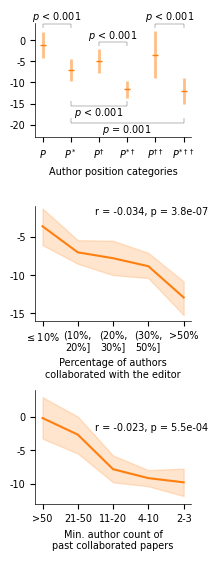

In [54]:
ax = plt.subplot(3, 1, 1)
plotAuthorPos(ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([0, -5, -10, -15, -20])
ax.set_yticklabels(['0', '-5', '-10', '-15', '-20'])
ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_xticklabels(['$P$', '$P^*$', '$P^{\dagger}$', '$P^{*\dagger}$','$P^{\dagger\dagger}$', '$P^{*\dagger\dagger}$'])
ax.set_xlabel('Author position categories')
ax.set_ylim(-23, 4)

ax = plt.subplot(3, 1, 2)
sns.lineplot(data=COIDelayPlot, x='BinPercent', y='RelativeDelay', ax=ax, color='#ff7f0e')
ax.set_xlabel('Percentage of authors\ncollaborated with the editor')
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xticklabels(['$\leq10$%', '(10%,\n20%]', '(20%,\n30%]', '(30%,\n50%]', '>50%'])
ax.set_yticks([-5, -10, -15])
ax.set_yticklabels(['-5', '-10', '-15'])
ax.set_ylim(-16, -1)

corr = pearsonr(COIDelayPlot.BinPercent, COIDelayPlot.RelativeDelay)
ax.text(1.5, -2, 'r = {:.3f}, p = {:.1e}'.format(corr[0], corr[1]))


ax = plt.subplot(3, 1, 3)
sns.lineplot(data=COIDelayPlot, x='PastAuthorBin', y='RelativeDelay', ax=ax, color='#ff7f0e')
ax.set_xlabel('Min. author count of\npast collaborated papers')
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([4, 3, 2, 1, 0])
ax.set_xticklabels(['2-3', '4-10', '11-20', '21-50', '>50'])
ax.set_yticks([0, -5, -10])
ax.set_yticklabels(['0', '-5', '-10'])
ax.set_ylim(-13, 4)

corr = pearsonr(COIDelayPlot.MinPastAuthorCount, COIDelayPlot.RelativeDelay)
ax.text(1.5, -2, 'r = -{:.3f}, p = {:.1e}'.format(corr[0], corr[1]))


set_size(4.2*cm, 11*cm, ax)
plt.tight_layout()

plt.savefig('./figures/delay_correlation.pdf', bbox_inches = 'tight', pad_inches = 0)